# Data Manipulation

## Importing necessary libraries and notebooks

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker

# Import the notebook without running its cells
from i_Getting_Started import visualize

We're going to try to manipulate the data arrays in various ways to try and improve the visibility of the algae.
From here on out, we're only going to work on **OLCI** and **ABI-GOES** images. We're going to test different visualization functions (**which we should probably try to unify into one function with optional parameters when they're written**).

## A bit of statistics
Here we plot the histograms **(on a logarithmic scale)** of the index values to see how the values are distributed for the 3 instrument images.

In [2]:
def histogram(file_path):
    # Importing data
    data = xr.open_dataset(file_path)
    index_key = 'fai_anomaly' if "abi" in file_path else 'nfai_mean'
    xlabel = 'Floating Algae Index Anomaly (FAI)' if "abi" in file_path else 'Normalized Floating Algae Index (NFAI)'
    title = file_path[25:28].upper() + ' FAI anomaly histogram on ' if "abi" in file_path else file_path[25:29].upper() + ' NFAI histogram on ' 
    index_data = data[index_key]
    # Flatten for histogram
    flat_values = index_data.values.flatten()
    # Remove NaN values for histogram (Changes nothing)
    #values = flat_values[~np.isnan(flat_values)]

    plt.hist(flat_values, bins=50, log = True)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title + str(data.time.values[0]) )
    plt.show()


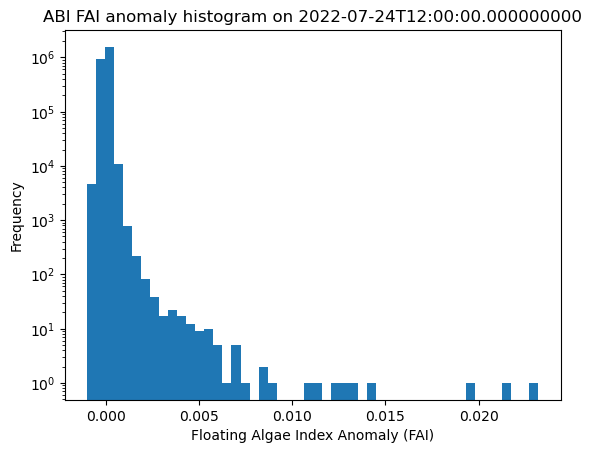

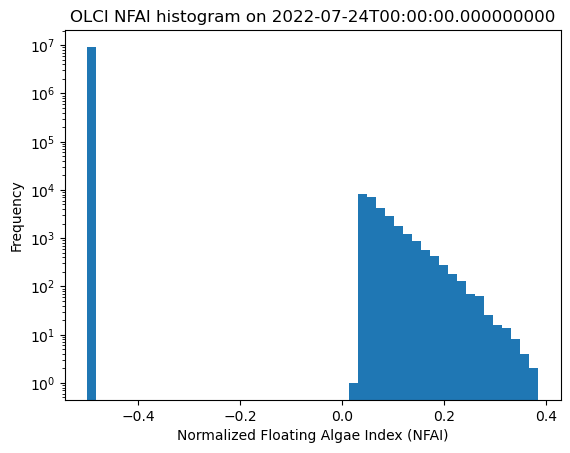

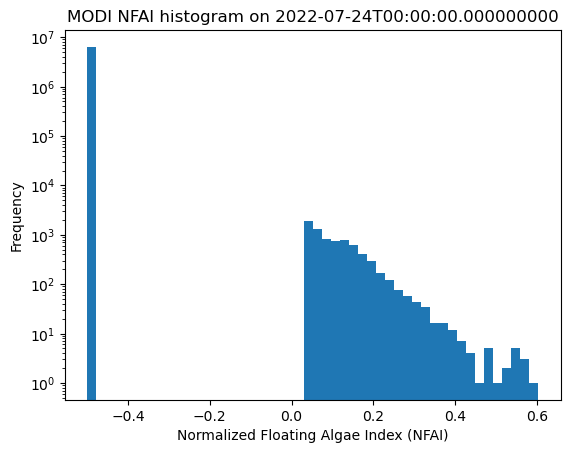

In [3]:
if __name__ == '__main__':
    abi_path = "/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_20220724_12-00.nc"
    histogram(abi_path)
    olci_path = "/media/yahia/ballena/CLS/olci-s3-global-lr/cls-olci-s3-global-lr_1d_20220724.nc" 
    histogram(olci_path)
    modis_path = "/media/yahia/ballena/CLS/modis-aqua-global-lr/cls-modis-aqua-global-lr_1d_20220724.nc"  
    histogram(modis_path)

All histograms show a very high frequency (about 10⁷) for lower values which correspond to land, clouds or sea. For this reason, we're going to try to change the scale of the colormaps to try and have more contrast between the algae and the rest of the image.

## OLCI

### Visualize_4: Setting a max for the scale
Note: vmax doesn't set a threshold for the image, it's just that the colors are saturated at vmax (For example if vmax is 0.01, values greater than 0.01 will still be shown but will have the same saturated color)

In [8]:
def visualize_4(file_path, lat_range=None, lon_range=None, color="viridis", vmax=0.1):
    # Load the netCDF data
    data = xr.open_dataset(file_path)
    
    # If ranges are specified, apply them to select the desired subset
    if lat_range:
        data = data.sel(latitude=slice(*lat_range))
    if lon_range:
        data = data.sel(longitude=slice(*lon_range))

    # Determine the index data and labels based on instrument used
    index_key = 'fai_anomaly' if "abi" in file_path else 'nfai_mean'
    colorbar_label = 'Floating Algae Index Anomaly (FAI)' if "abi" in file_path else 'Normalized Floating Algae Index (NFAI)'
    title = 'FAI anomaly across the selected region on ' if "abi" in file_path else 'NFAI across the selected region on '
    
    # Extract relevant data (NFAI or FAI anomaly)
    index_data = data[index_key]

    # Set non-positive values to a very small negative number, close to zero
    index_data = xr.where(index_data > 0, index_data, -0.1)
    
    # Set up a plot with geographic projections
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Customize the map with coastlines and features
    ax.coastlines(resolution='10m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Adding grid lines and disabling labels on the top and right
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Plot the data with the modified contrast
    im = index_data.plot(ax=ax, x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                         cmap=color, add_colorbar=True, extend='both',
                         vmin=-0.01, vmax=vmax,  # Here we set the scale to max out at 0.5
                         cbar_kwargs={'shrink': 0.35})

    # Add color bar details
    im.colorbar.set_label(colorbar_label)
    
    # Show the plot with title
    plt.title(title + str(data.time.values[0]))
    plt.show()

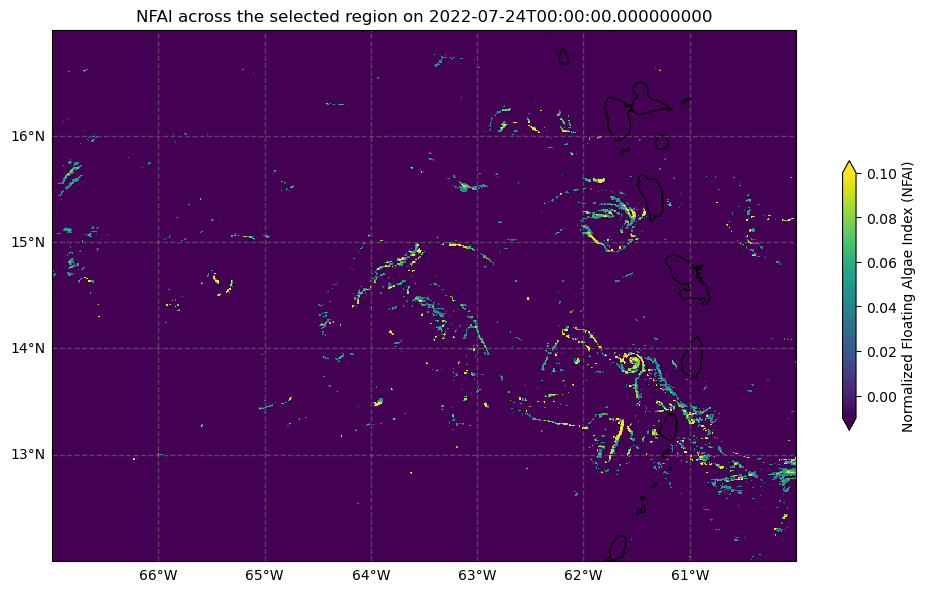

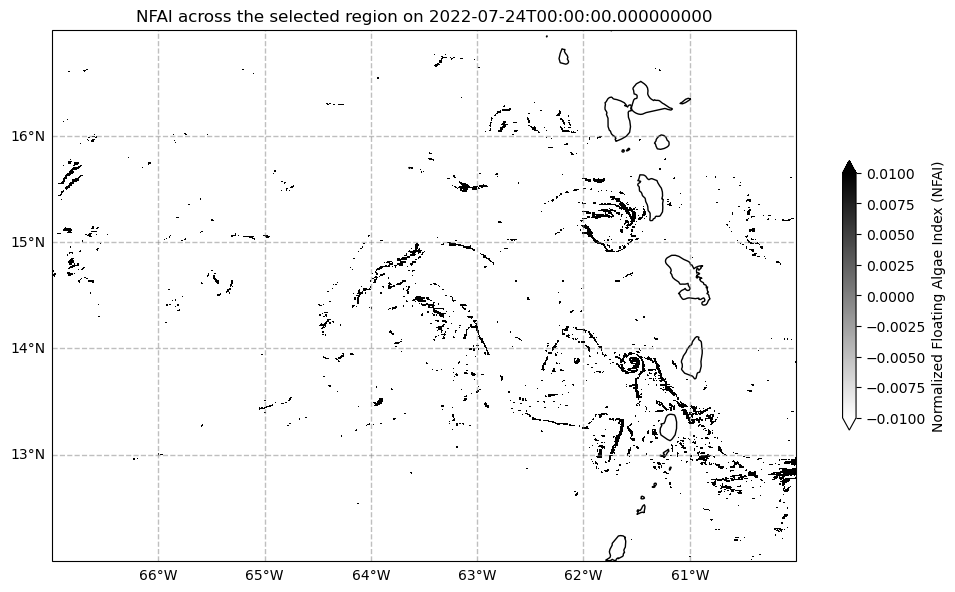

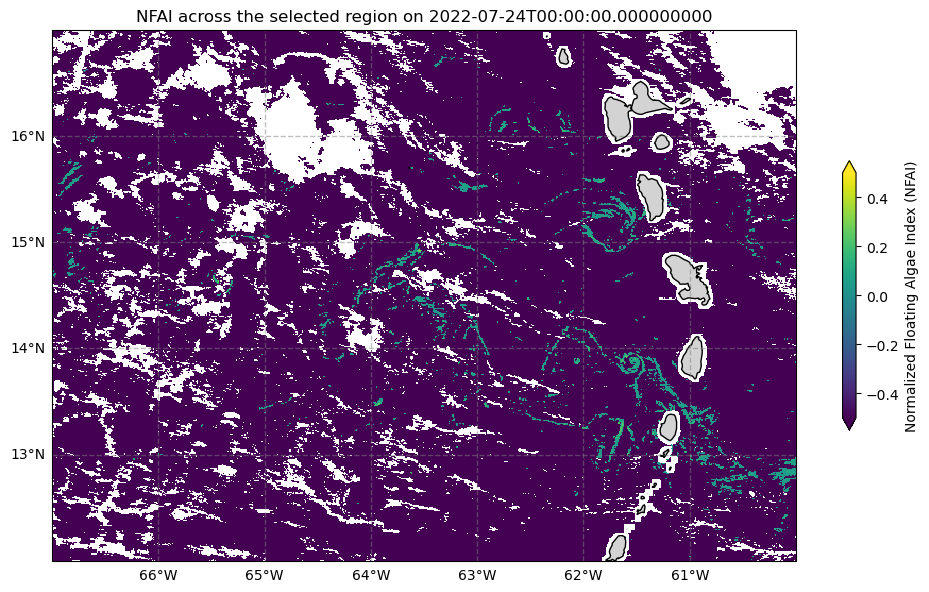

In [9]:
if __name__ == '__main__':
    path = "/media/yahia/ballena/CLS/olci-s3-global-lr/cls-olci-s3-global-lr_1d_20220724.nc" 
    visualize_4(path,(12,17),(-67,-60))
    visualize_4(path,(12,17),(-67,-60),"binary",vmax=0.01)
    visualize(path,(12,17),(-67,-60))

Another idea we've implemented here is to decrease the max ***vmax*** for the colorbar so that positive values change color very quickly. This method is very effective to distinguish the algae from the rest of the image, ***the smaller vmax is, the higher the contrast***. A good idea to try and maximize the contrast is to choose the binary cmap and set vmax to a very low value like ***vmax = 0.01*** for example (alternatively, we can simply set apply a map to the data array that makes all positive values very large, but I believe this method is computationally more efficient). 

For our purposes, **visualize_4** seems to be the best display function.

## ABI-GOES

### Trying these functions on ABI-GOES images

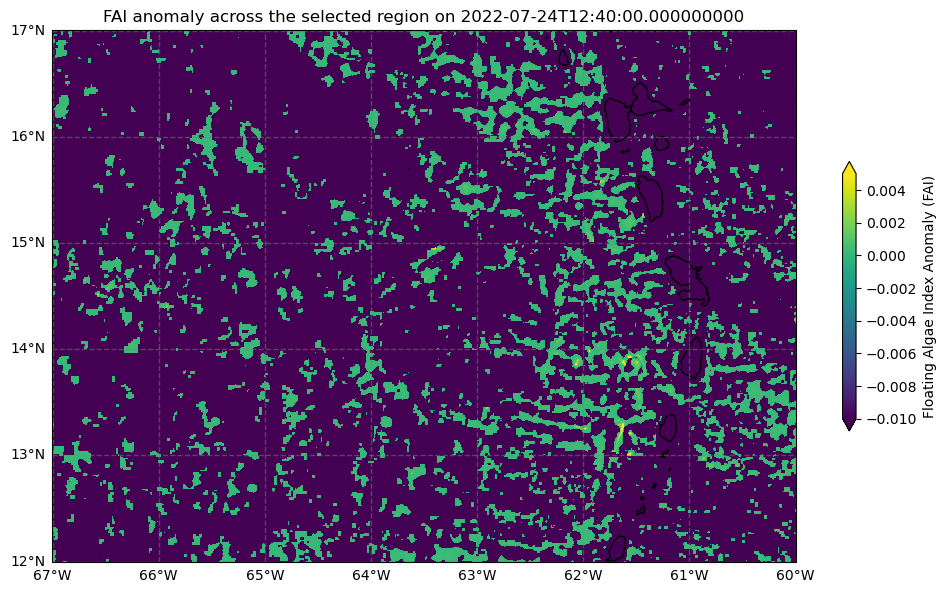

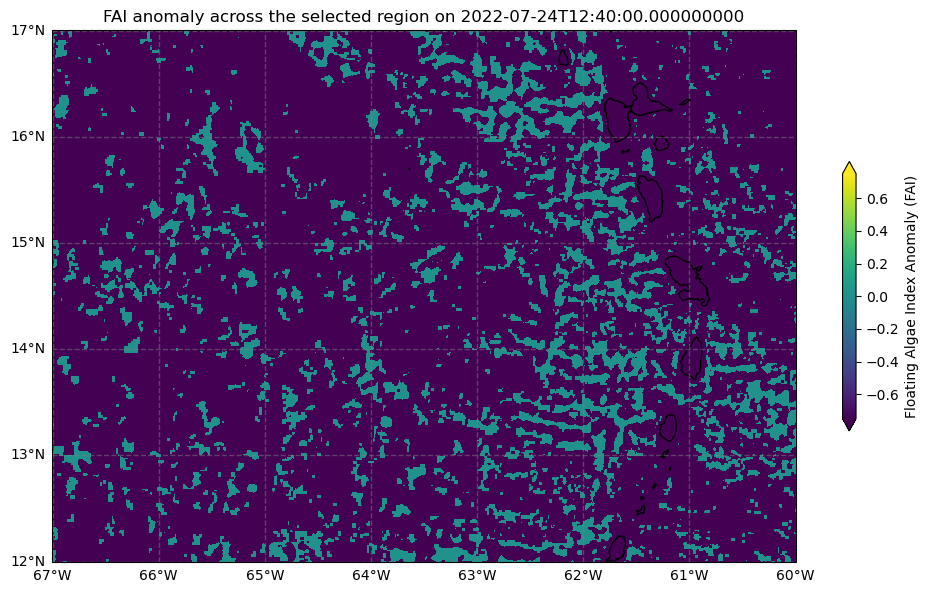

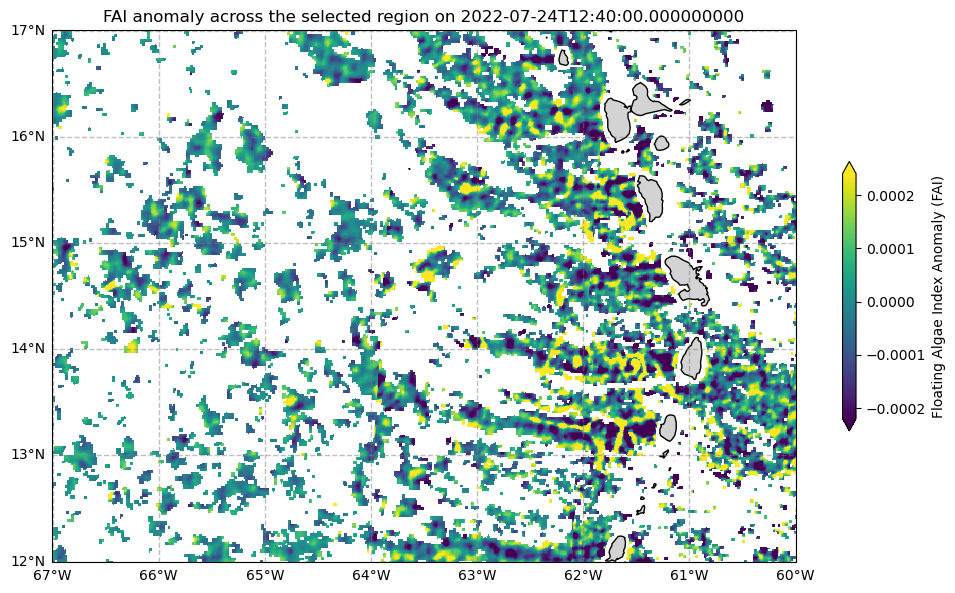

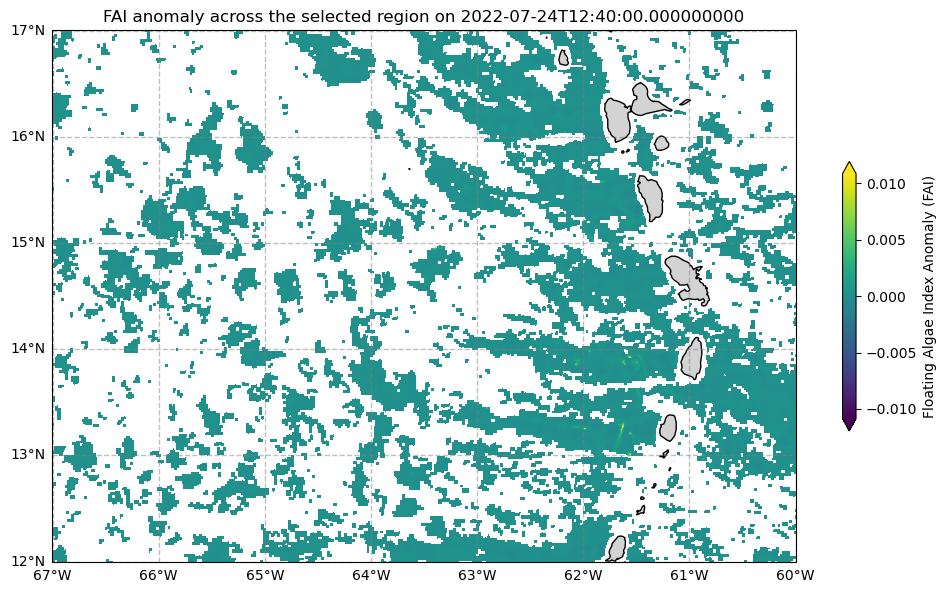

In [10]:
if __name__ == '__main__':
    path = "/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_20220724_12-40.nc" 
    visualize_4(path,(12,17),(-67,-60),vmax = 0.005)
    visualize_3(path,(12,17),(-67,-60))
    visualize_2(path,(12,17),(-67,-60))
    visualize(path,(12,17),(-67,-60))

Applying these display functions on ABI-GOES images doesn't seem to produce the same results as on OLCI, the default visualization function still isn't very useful for detecting the algae, the second one, *visualize_2* shows good contrast in the non-nan values, **we can see in yellow the same patterns that are more clear in the OLCI image**, *visualize_3* and *visualize_4* don't seem very useful for ABI-GOES images, because they leave in a lot of pixels that do not correspond to algae.

A good idea now would be to either try and manipulate the function *visualize_2* by changing the percentiles, or write another function that shows only pixels above a certain threshold (**0.32767** ?) on the FAI.

### Visualize_5: Fixing a positive threshold

In [15]:
def visualize_5(file_path, lat_range=None, lon_range=None, color="viridis", vmax=0.001, threshold=0):
    # Load the netCDF data
    data = xr.open_dataset(file_path)
    
    # If ranges are specified, apply them to select the desired subset
    if lat_range:
        data = data.sel(latitude=slice(*lat_range))
    if lon_range:
        data = data.sel(longitude=slice(*lon_range))

    # Determine the index data and labels based on instrument used
    index_key = 'fai_anomaly' if "abi" in file_path else 'nfai_mean'
    colorbar_label = 'Floating Algae Index Anomaly (FAI)' if "abi" in file_path else 'Normalized Floating Algae Index (NFAI)'
    title = 'FAI anomaly across the selected region on ' if "abi" in file_path else 'NFAI across the selected region on '
    
    # Extract relevant data (NFAI or FAI anomaly)
    index_data = data[index_key]

    # Mask the data to only show values above the threshold
    index_data = xr.where(index_data > threshold, index_data, np.nan)
    
    # Set up a plot with geographic projections
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Customize the map with coastlines and features
    ax.coastlines(resolution='10m', color='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')

    # Adding grid lines and disabling labels on the top and right
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Plot the data with the modified contrast
    im = index_data.plot(ax=ax, x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                         cmap=color, add_colorbar=True, extend='both',
                         vmin=threshold, vmax=vmax,
                         cbar_kwargs={'shrink': 0.35})

    # Add color bar details
    im.colorbar.set_label(colorbar_label)
    
    # Show the plot with title
    plt.title(title + str(data.time.values[0]))
    plt.show()

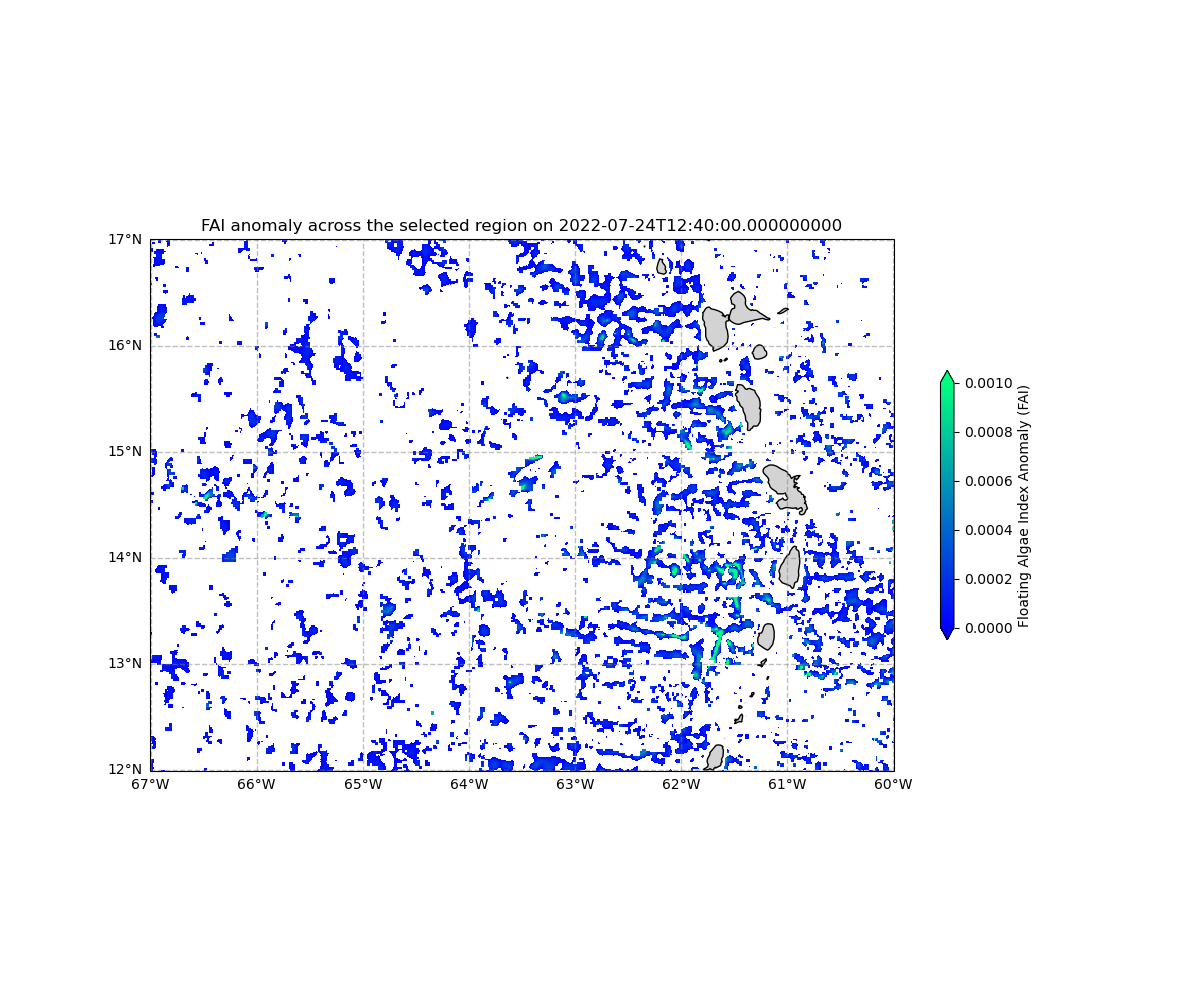

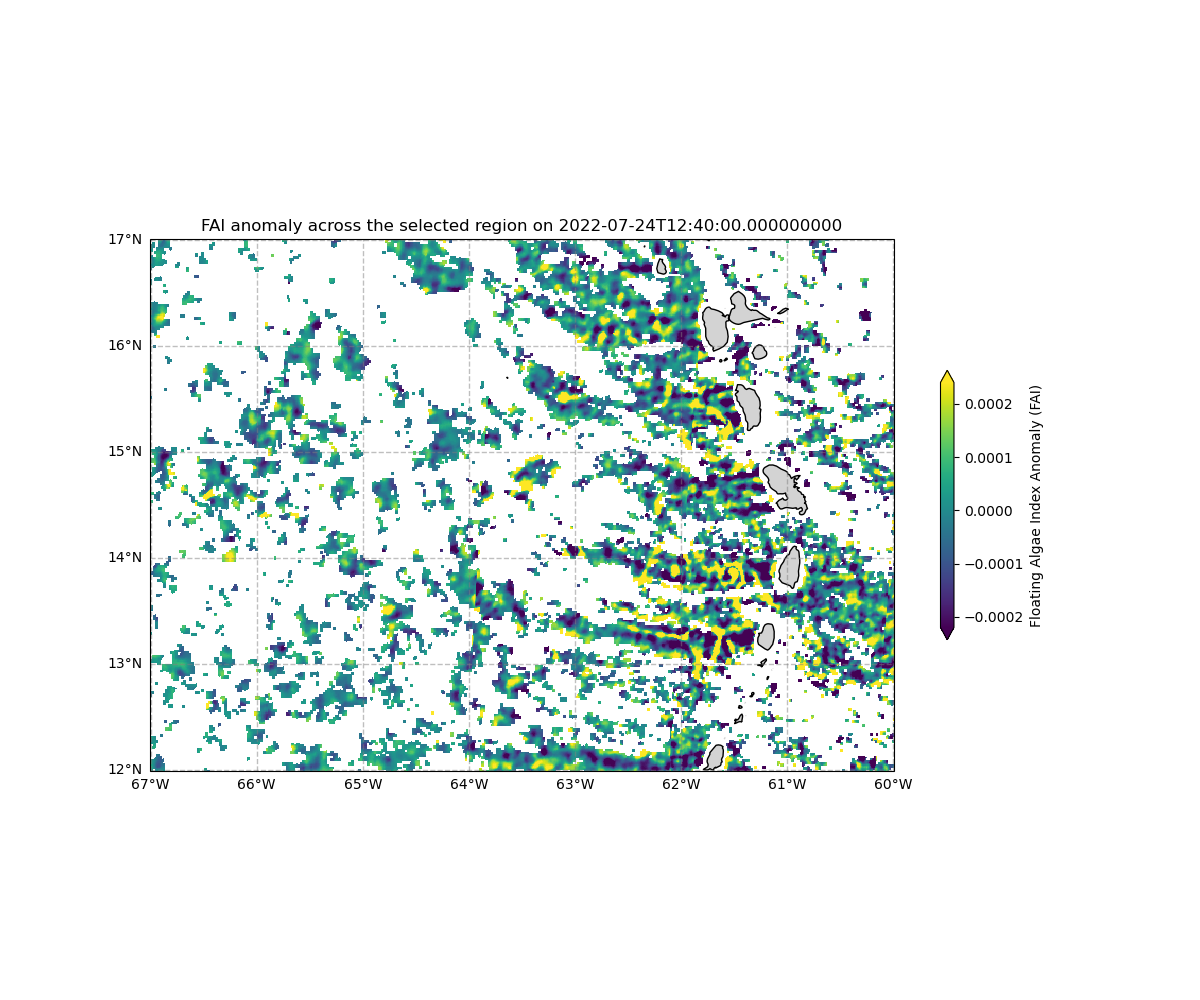

In [16]:
if __name__ == '__main__':
    path = "/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_20220724_12-40.nc" 
    visualize_5(path,(12,17),(-67,-60),vmax = 0.001,color="winter",threshold=0)
    visualize_2(path,(12,17),(-67,-60))

- Aside from the positive threshold, this time all values under the threshold are set to nan, so even with the threshold set to 0, it's different.
- Setting the threshold to **0.0002** does seem to single out the areas where sargassum are most dense, but it also leaves out areas where sargassum could be present.
- The problem is we're comparing to the density of the result of the function visualize_2, which depends directly on the colormap scale.
- So maybe the best approach would be to simply choose fix **threshold=0**.
- **NOTE: In the past methods, we made all the nan values zero (or negative), this time we made all the negative values nan.**

The best parameters so far for this particular date seem to be **threshold=0**, **vmax=0.01** and **color="winter","cool","bwr"**.

## Averaging ABI-GOES images for a given day:
We could try to average the images for a given day to try and reproduce the images we see on the CLS datastore.
GOES doesn't cover the same region from image to image, so we can't directly calculate the average, we'll have to calculate an average only when there is data (non-nan values). We're going to work on the same day of 24/07/2022.

### Time List Generator
First, we should write a function that generates a lost of the times in the time intervals we need to make the importation of data easier. 

In [25]:
def time_list(start_time, end_time, interval):
    """
    Generate a list of datetime strings in the format 'YYYYMMDD_HH-MM' between start_time and end_time at intervals of 'interval' minutes.
    
    Parameters:
    - start_time (datetime): The start time.
    - end_time (datetime): The end time.
    - interval (int): The interval in minutes between each time point.

    Returns:
    - times (list of str): List of formatted datetime strings.
    """
    
    # Generate a list of times at the specified interval
    times = []
    current_time = start_time
    while current_time <= end_time:
        times.append(current_time.strftime('%Y%m%d_%H-%M'))
        current_time += timedelta(minutes=interval)

    return times

### Calculating aggregate data
We should also write a function to calculate the aggregate (mean) data on the time frame we want using the previous function time_list. 
Note: **This is only adapted to ABI-GOES for the moment.**

In [28]:
def calculate_aggregate_data(time_list, threshold=0):
    """
    Calculate the aggregate data of algae presence over a given time range based on a list of times.

    Parameters:
    - time_list (list of str): List of formatted datetime strings in the format 'YYYYMMDD_HH-MM'.
    - threshold (float): The threshold above which data is considered.

    Returns:
    - average_algae_distribution (DataArray): The mean algae distribution.
    """
    aggregate_data_list = []

    # Loop over each time in the time list, loading the data and adding it to the list
    for time_str in time_list:
        file_path = f"/media/yahia/ballena/CLS/abi-goes-global-hr/cls-abi-goes-global-hr_1d_{time_str}.nc"
        data = xr.open_dataset(file_path)

        # Extract the index of interest and drop the 'time' coordinate
        algae_data = data['fai_anomaly'].squeeze(drop=True)

        # Mask the data to include only algae (values greater than the threshold)
        algae_masked = algae_data.where(algae_data > threshold)

        # Add the masked data to our list
        aggregate_data_list.append(algae_masked)

    # Combine the data along a new dimension, then calculate the mean along that dimension
    aggregate_data = xr.concat(aggregate_data_list, dim='new_dim')
    average_algae_distribution = aggregate_data.mean(dim='new_dim')

    return average_algae_distribution
